In [2]:
import redback
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
import corner
from bilby.core.prior import Constraint, PriorDict, Uniform, Sine
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

No module named 'lalsimulation'
lalsimulation is not installed. Some EOS based models will not work. Please use bilby eos or pass your own EOS generation class to the model


In [4]:
bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

[1.94770377e+14 2.57913110e+14 3.08738117e+14 3.44949775e+14
 3.97287891e+14 4.81730482e+14 6.21093083e+14 8.16711950e+14
 1.14683976e+15]


[5000000000.0,
 194770377372101.4,
 257913110025249.2,
 308738116672272.25,
 344949774531146.6,
 397287890568202.3,
 481730482385753.06,
 621093082892117.8,
 816711949886849.0,
 1146839759677006.2,
 2e+17]

In [4]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,100,100) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=frequencies[7])
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    return constrained_params



In [5]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000

samples=priors.sample(1000)
afterglow_data=pd.DataFrame.from_dict(samples)

In [6]:
time=np.linspace(0.1,100,100)
count=0
for i in range(1000):
    flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
                base_model='tophat', **afterglow_data.iloc[i], output_format='flux_density', frequency=frequencies[7])
    if np.array(afterglow_data['thv'])[i]>np.array(afterglow_data['thc'])[i] == False:
        print('failed')
    if max(flux)<10e-12:
        print('failed flux')
    if time[np.argmax(flux)] >200:
        print('failed time')
        count+=1
afterglow_data

,redshift,thv,loge0,thc,logn0,p,logepse,logepsb,ksin,g0
0,0.01,1.377406,47.953715,0.048998,0.029531,2.3,-1.25,-2.5,1.0,1000.0
1,0.01,0.481781,52.529495,0.059166,1.074899,2.3,-1.25,-2.5,1.0,1000.0
2,0.01,1.550153,48.527237,0.029606,-1.539244,2.3,-1.25,-2.5,1.0,1000.0
3,0.01,0.964068,47.444502,0.097430,1.449541,2.3,-1.25,-2.5,1.0,1000.0
4,0.01,0.910366,52.911960,0.094908,-2.726055,2.3,-1.25,-2.5,1.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
995,0.01,0.921850,49.084204,0.076002,-0.621246,2.3,-1.25,-2.5,1.0,1000.0
996,0.01,1.351071,51.777366,0.079877,1.305163,2.3,-1.25,-2.5,1.0,1000.0
997,0.01,0.632607,48.213744,0.067158,-3.661072,2.3,-1.25,-2.5,1.0,1000.0
998,0.01,0.626717,49.301397,0.049587,-2.719509,2.3,-1.25,-2.5,1.0,1000.0


In [6]:
count

0

In [12]:
#priors

that_priorsoff = redback.priors.get_priors(model='tophat')
that_priorsoff['p']=  2.3
that_priorsoff['loge0']= Uniform(minimum=47, maximum=52, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorsoff['redshift']= 0.01
that_priorsoff['logepse']= -1.25
that_priorsoff['logepsb']= -2.5
that_priorsoff['ksin']= 1.0
that_priorsoff['g0']= 1000
that_priorsoff['logn0']=Uniform(minimum=-2, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)

that_priorson = redback.priors.get_priors(model='tophat')
that_priorson['p']=  2.3
that_priorson['loge0']= Uniform(minimum=46, maximum=50, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
that_priorson['redshift']= 0.01
that_priorson['logepse']= -1.25
that_priorson['logepsb']= -2.5
that_priorson['ksin']= 1.0
that_priorson['g0']= 1000
that_priorson['logn0']=Uniform(minimum=-2.5, maximum=1.5, name='logn0', latex_label='$\\log_{10}n_{\\mathrm{ism}}$', unit=None, boundary=None)
that_priorson['thv']=Sine(minimum=0, maximum=0.3, name='thv', latex_label='$\\theta_{\\mathrm{observer}}$', unit=None, boundary=None)

kn_priors = redback.priors.get_priors(model='two_layer_stratified_kilonova')
kn_priors['redshift']=0.01
#kn_priors['beta']=Uniform(minimum=3.001, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)
samples=kn_priors.sample(5000)
kn_data= pd.DataFrame.from_dict(samples)
kn_data

,redshift,mej,vej_1,vej_2,kappa,beta
0,0.01,0.020275,0.136958,0.463541,17.214020,6.230598
1,0.01,0.012708,0.115624,0.395727,12.052329,3.852015
2,0.01,0.033475,0.108196,0.454375,25.095816,3.714433
3,0.01,0.014251,0.159804,0.333950,27.485352,6.854325
4,0.01,0.034646,0.108644,0.376975,21.023178,7.449658
...,...,...,...,...,...,...
4995,0.01,0.012793,0.081640,0.456881,23.346782,7.539508
4996,0.01,0.011687,0.138365,0.340428,13.192201,7.831412
4997,0.01,0.041095,0.131635,0.438702,2.076983,6.073021
4998,0.01,0.036642,0.124525,0.387822,9.706798,3.665229


In [21]:
kn_priors

{'redshift': DeltaFunction(peak=0.01, name=None, latex_label=None, unit=None),
 'mej': Uniform(minimum=0.01, maximum=0.05, name='mej', latex_label='$M_{\\mathrm{ej}}[M_{\\odot}]$', unit=None, boundary=None),
 'vej_1': Uniform(minimum=0.05, maximum=0.2, name='vej_1', latex_label='$v_{\\mathrm{ej}-1}[c]$', unit=None, boundary=None),
 'vej_2': Uniform(minimum=0.3, maximum=0.5, name='vej_2', latex_label='$v_{\\mathrm{ej}-2}[c]$', unit=None, boundary=None),
 'kappa': Uniform(minimum=1, maximum=30, name='kappa', latex_label='$\\kappa$', unit=None, boundary=None),
 'beta': Uniform(minimum=1.5, maximum=8, name='beta', latex_label='$\\beta$', unit=None, boundary=None)}

In [4]:
def afterglowoff(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.84, loge0=49.2 , thc= 0.06, logn0=0.05, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def afterglowon(time, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.14, loge0=47.7 , thc= 0.06, logn0=0.35, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000, thw=3,
        beta=4, output_format='flux_density', frequency=frequency)
    return ag_fluxd

def sampleoff(time,frequency):
    sample=that_priorsoff.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]<= 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorsoff.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def sampleon(time,frequency):
    sample=that_priorson.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    
    while time[np.argmax(ag_fluxd)]> 0.1 or np.any(ag_fluxd < 10e-25):
        sample=that_priorson.sample(1)
        ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
            base_model='tophat', **sample, output_format='flux_density', frequency=frequency)
    
    return ag_fluxd

def agsample(time, frequency):
    sample=priors.sample(1)
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', frequency=frequency, **sample)
    return ag_fluxd

def knsample(time, frequency, **sample):
    
    kn_fluxd =  redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
        base_model='two_layer_stratified_kilonova', output_format='flux_density', frequency=frequency, **sample)
   
    return kn_fluxd



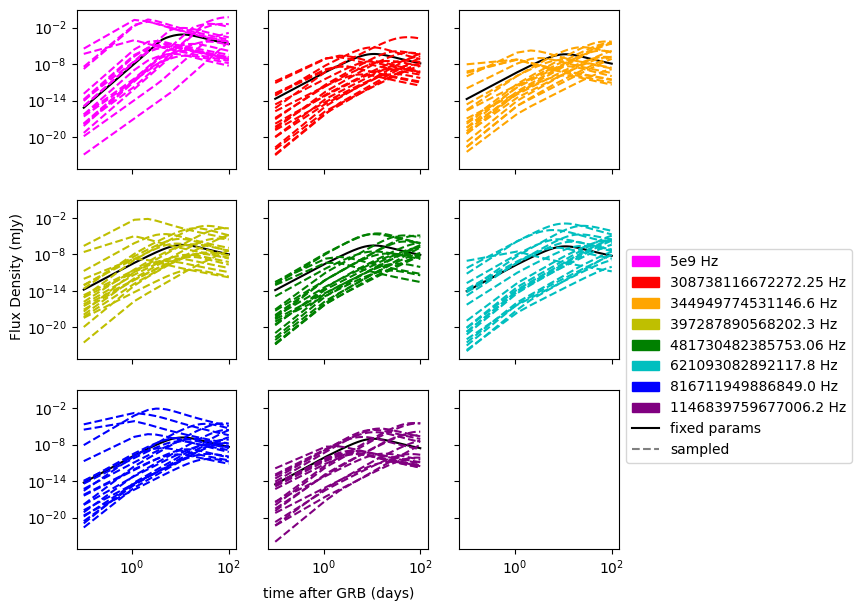

In [9]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7),sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowoff(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleoff(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleoff(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleoff(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleoff(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleoff(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleoff(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleoff(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleoff(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')


f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8,fix,samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

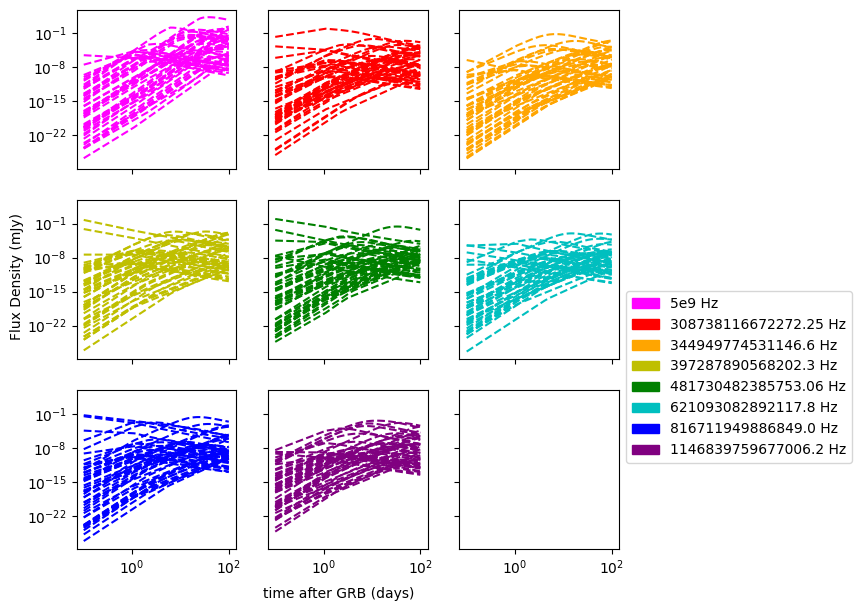

In [18]:
#using constraints- not filtered by on/off axis
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7),sharex=True, sharey=True)

for i in range(50):
    ax[0,0].loglog(time, agsample(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, agsample(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, agsample(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, agsample(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, agsample(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, agsample(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, agsample(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, agsample(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')
    
f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

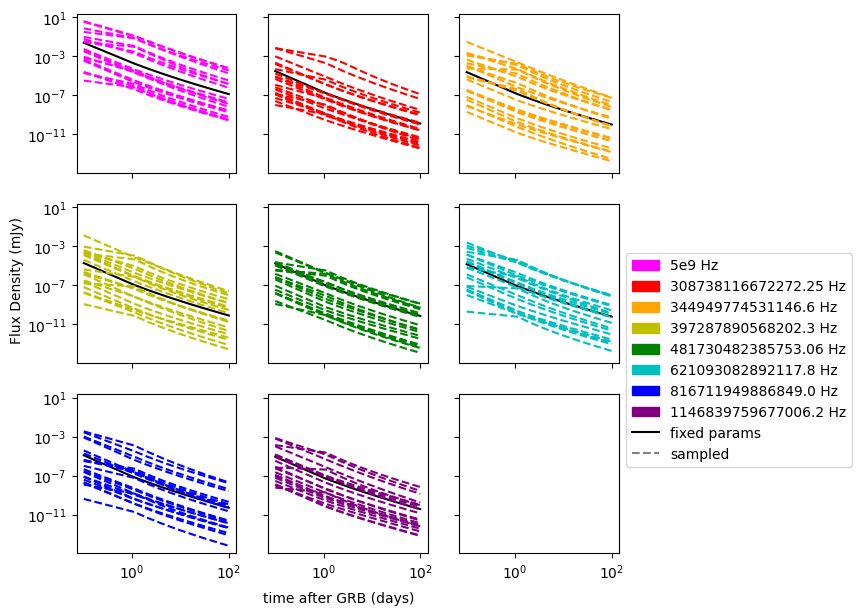

In [42]:
time= np.linspace(0.1,100,100)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

for i in range(20):
    ax[0,0].loglog(time, sampleon(time, frequencies[0]), c='magenta', ls='--')
    ax[0,1].loglog(time, sampleon(time, frequencies[1]), c='r', ls='--')
    ax[0,2].loglog(time, sampleon(time, frequencies[2]), c='orange', ls='--')
    ax[1,0].loglog(time, sampleon(time, frequencies[3]), c='y', ls='--')
    ax[1,1].loglog(time, sampleon(time, frequencies[4]), c='g', ls='--')
    ax[1,2].loglog(time, sampleon(time, frequencies[5]), c='c', ls='--')
    ax[2,0].loglog(time, sampleon(time, frequencies[6]), c='b', ls='--')
    ax[2,1].loglog(time, sampleon(time, frequencies[7]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, fix, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

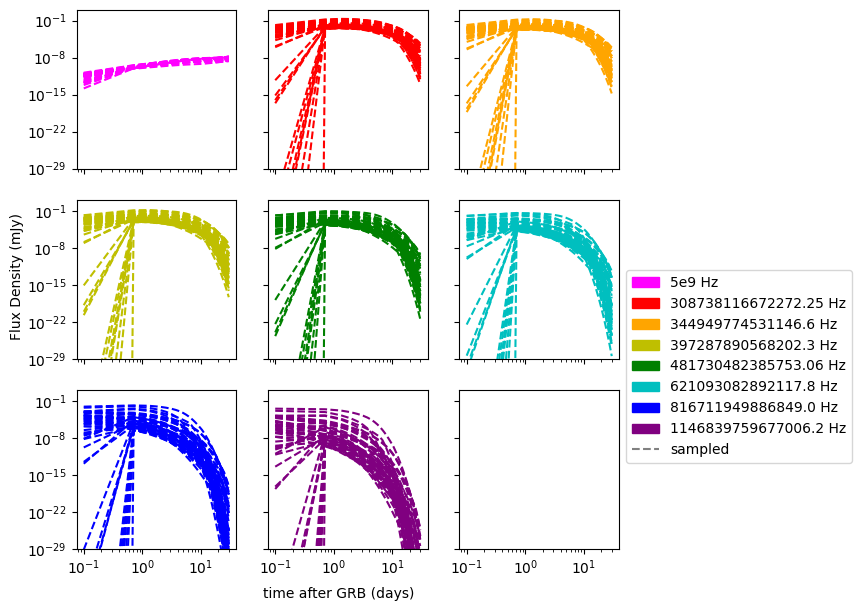

In [32]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

for i in range(50):
    ax[0,0].loglog(time, knsample(time, frequencies[0],**kn_data.iloc[i]), c='magenta', ls='--')
    ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[i]), c='r', ls='--')
    ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[i]), c='orange', ls='--')
    ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[i]), c='y', ls='--')
    ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[i]), c='g', ls='--')
    ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[i]), c='c', ls='--')
    ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[i]), c='b', ls='--')
    ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[i]), c='purple', ls='--')    
    #ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')
plt.ylim(10e-30,10) 

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8, samp], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

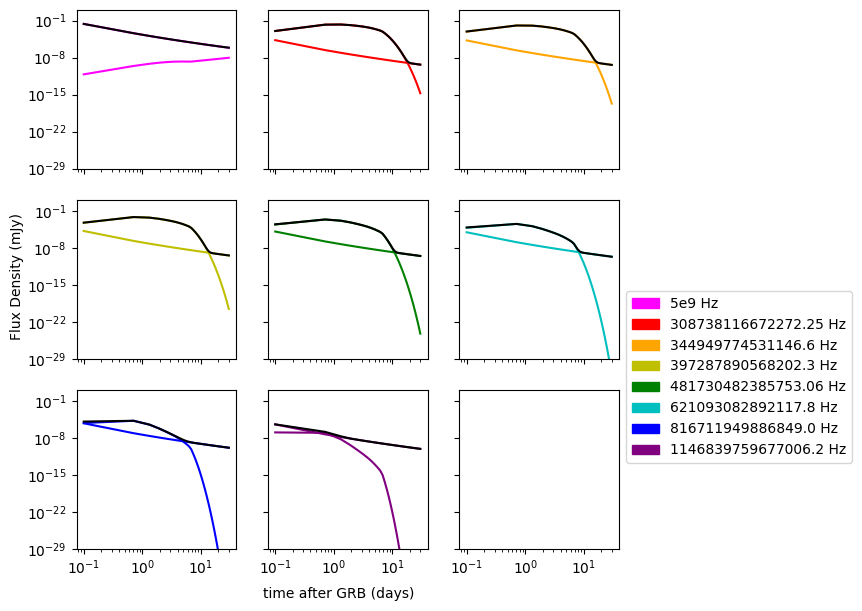

In [51]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowon(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, knsample(time, frequencies[0], **kn_data.iloc[1]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[1]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[1]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[1]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[1]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[1]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[1]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[1]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, afterglowon(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[1]), c='k')
ax[0,1].loglog(time, afterglowon(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[1]), c='k')
ax[0,2].loglog(time, afterglowon(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[1]), c='k')
ax[1,0].loglog(time, afterglowon(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[1]), c='k')
ax[1,1].loglog(time, afterglowon(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[1]), c='k')
ax[1,2].loglog(time, afterglowon(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[1]), c='k')
ax[2,0].loglog(time, afterglowon(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[1]), c='k')
ax[2,1].loglog(time, afterglowon(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[1]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

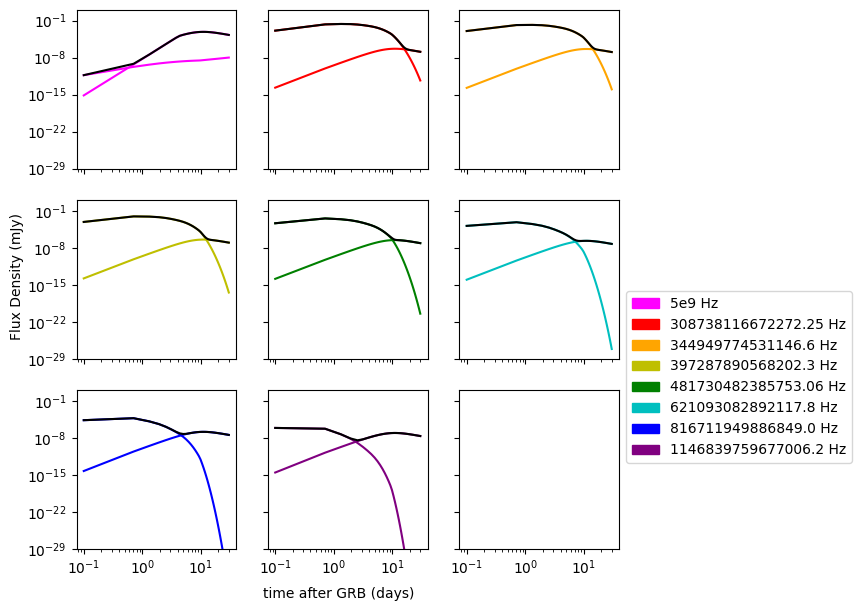

In [195]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]), c='magenta')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]), c='r')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]), c='orange')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]), c='y')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]), c='g')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]), c='c')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]), c='b')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, knsample(time, frequencies[0], **kn_data.iloc[13]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[13]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[13]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[13]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[13]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[13]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[13]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[13]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, afterglowoff(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[13]), c='k')
ax[0,1].loglog(time, afterglowoff(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[13]), c='k')
ax[0,2].loglog(time, afterglowoff(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[13]), c='k')
ax[1,0].loglog(time, afterglowoff(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[13]), c='k')
ax[1,1].loglog(time, afterglowoff(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[13]), c='k')
ax[1,2].loglog(time, afterglowoff(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[13]), c='k')
ax[2,0].loglog(time, afterglowoff(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[13]), c='k')
ax[2,1].loglog(time, afterglowoff(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[13]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



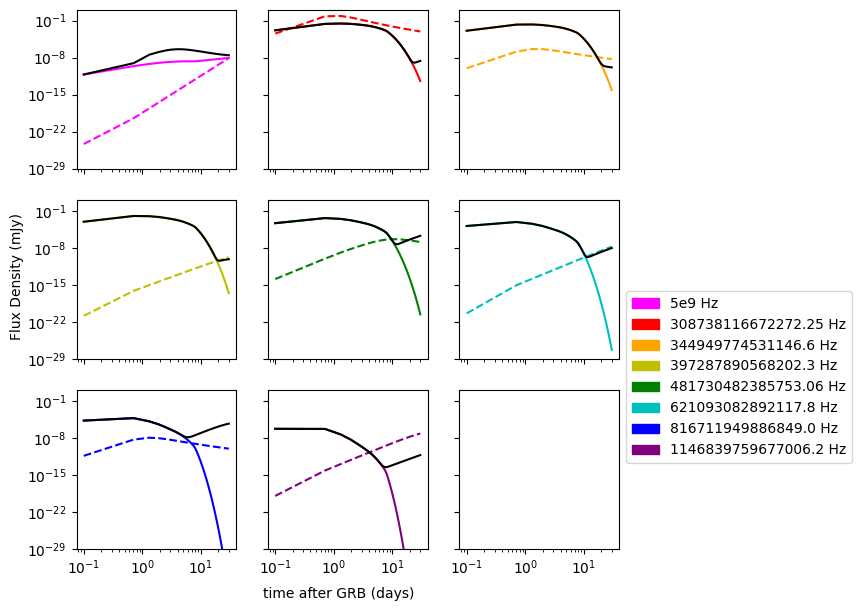

In [34]:
time= np.linspace(0.1,30,50)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7,7), sharex=True, sharey=True)

ax[0,0].loglog(time, agsample(time, frequencies[0]), c='magenta', ls='--')
ax[0,1].loglog(time, agsample(time, frequencies[1]), c='r', ls='--')
ax[0,2].loglog(time, agsample(time, frequencies[2]), c='orange', ls='--')
ax[1,0].loglog(time, agsample(time, frequencies[3]), c='y', ls='--')
ax[1,1].loglog(time, agsample(time, frequencies[4]), c='g', ls='--')
ax[1,2].loglog(time, agsample(time, frequencies[5]), c='c', ls='--')
ax[2,0].loglog(time, agsample(time, frequencies[6]), c='b', ls='--')
ax[2,1].loglog(time, agsample(time, frequencies[7]), c='purple', ls='--')    
#ax[2,2].plot(time, sampled(time, frequencies[8]), c='k', ls='--')

ax[0,0].loglog(time, knsample(time, frequencies[0],**kn_data.iloc[13]), c='magenta')
ax[0,1].loglog(time, knsample(time, frequencies[1],**kn_data.iloc[13]), c='r')
ax[0,2].loglog(time, knsample(time, frequencies[2],**kn_data.iloc[13]), c='orange')
ax[1,0].loglog(time, knsample(time, frequencies[3],**kn_data.iloc[13]), c='y')
ax[1,1].loglog(time, knsample(time, frequencies[4],**kn_data.iloc[13]), c='g')
ax[1,2].loglog(time, knsample(time, frequencies[5],**kn_data.iloc[13]), c='c')
ax[2,0].loglog(time, knsample(time, frequencies[6],**kn_data.iloc[13]), c='b')
ax[2,1].loglog(time, knsample(time, frequencies[7],**kn_data.iloc[13]), c='purple')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

ax[0,0].loglog(time, agsample(time, frequencies[0]) + knsample(time, frequencies[0],**kn_data.iloc[13]), c='k')
ax[0,1].loglog(time, agsample(time, frequencies[1]) + knsample(time, frequencies[1],**kn_data.iloc[13]), c='k')
ax[0,2].loglog(time, agsample(time, frequencies[2]) + knsample(time, frequencies[2],**kn_data.iloc[13]), c='k')
ax[1,0].loglog(time, agsample(time, frequencies[3]) + knsample(time, frequencies[3],**kn_data.iloc[13]), c='k')
ax[1,1].loglog(time, agsample(time, frequencies[4]) + knsample(time, frequencies[4],**kn_data.iloc[13]), c='k')
ax[1,2].loglog(time, agsample(time, frequencies[5]) + knsample(time, frequencies[5],**kn_data.iloc[13]), c='k')
ax[2,0].loglog(time, agsample(time, frequencies[6]) + knsample(time, frequencies[6],**kn_data.iloc[13]), c='k')
ax[2,1].loglog(time, agsample(time, frequencies[7]) + knsample(time, frequencies[7],**kn_data.iloc[13]), c='k')
#ax[2,2].loglog(time, afterglowon(time, frequencies[8]), c='k')

f1 = mpatches.Patch(color='magenta', label='5e9 Hz')
f2 = mpatches.Patch(color='r', label='308738116672272.25 Hz')
f3 = mpatches.Patch(color='orange', label='344949774531146.6 Hz')
f4 = mpatches.Patch(color='y', label='397287890568202.3 Hz')
f5 = mpatches.Patch(color='g', label='481730482385753.06 Hz')
f6 = mpatches.Patch(color='c', label='621093082892117.8 Hz')
f7 = mpatches.Patch(color='b', label='816711949886849.0 Hz')
f8 = mpatches.Patch(color='purple', label='1146839759677006.2 Hz')
#f9 = mpatches.Patch(color='k', label='2e17 Hz')
#fix = Line2D([0],[0],color='k', ls='solid', label='fixed params')
#samp = Line2D([0],[0],color='grey', ls='dashed',label='sampled')

plt.ylim(10e-30,10) 

fig.text(0.5, 0.04, 'time after GRB (days)', ha='center')
fig.text(0.03, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.legend(handles=[f1,f2,f3,f4,f5,f6,f7,f8], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



In [6]:
time= np.linspace(0.1,40,250)

onaxis_ag= pd.read_csv('on_axis_samples3.csv')
onaxis_ag.drop('Unnamed: 0', axis=1, inplace=True)
offaxis_ag= pd.read_csv('off_axis_samples.csv')
offaxis_ag.drop('Unnamed: 0', axis=1, inplace=True)
    

In [16]:
onaxis_ag

,redshift,thv,loge0,thc,logn0,p,logepse,logepsb,ksin,g0
0,0.01,0.034296,49.107607,0.090857,-0.039942,2.3,-1.25,-2.5,1.0,1000.0
1,0.01,0.044024,50.904826,0.083933,0.984190,2.3,-1.25,-2.5,1.0,1000.0
2,0.01,0.014155,49.677477,0.057204,-0.044956,2.3,-1.25,-2.5,1.0,1000.0
3,0.01,0.023402,51.019945,0.035366,-0.133276,2.3,-1.25,-2.5,1.0,1000.0
4,0.01,0.032789,49.495134,0.019737,-1.684684,2.3,-1.25,-2.5,1.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
4995,0.01,0.016480,52.131077,0.076313,-3.271163,2.3,-1.25,-2.5,1.0,1000.0
4996,0.01,0.037955,47.218524,0.025182,-2.345447,2.3,-1.25,-2.5,1.0,1000.0
4997,0.01,0.044072,49.308736,0.069065,-0.197647,2.3,-1.25,-2.5,1.0,1000.0
4998,0.01,0.037630,49.584083,0.050288,-2.736956,2.3,-1.25,-2.5,1.0,1000.0


In [9]:
time= np.linspace(0.1,40,300)
maximumoff= []
minimumoff= []
loweroff=[]
medianoff=[]
upperoff=[]

for j in range(1,10): #loop each freqeuncy
    maximum= []
    minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(250): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
                base_model='tophat', output_format='flux_density', frequency=frequencies[j], **offaxis_ag.iloc[k])
            pointintime.append(offflux[i])
            
        maximum.append(max(pointintime))
        minimum.append(min(pointintime))
        lower.append(np.percentile(pointintime,16))
        median.append(np.percentile(pointintime,50))
        upper.append(np.percentile(pointintime,84))
        
    maximumoff.append(maximum)
    minimumoff.append(minimum)
    loweroff.append(lower)
    medianoff.append(median)
    upperoff.append(upper)
        

KeyboardInterrupt: 

In [10]:
time= np.linspace(0.1,40,300)
maximumon= []
minimumon= []
loweron=[]
medianon=[]
upperon=[]

for j in range(1,10): #loop each freqeuncy
    maximum= []
    minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(100): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
                base_model='tophat', output_format='flux_density', frequency=frequencies[j], **onaxis_ag.iloc[k])
            pointintime.append(offflux[i])
            
        maximum.append(max(pointintime))
        minimum.append(min(pointintime))
        lower.append(np.percentile(pointintime,16))
        median.append(np.percentile(pointintime,50))
        upper.append(np.percentile(pointintime,84))
        
    maximumon.append(maximum)
    minimumon.append(minimum)
    loweron.append(lower)
    medianon.append(median)
    upperon.append(upper)
        

In [18]:
print(upperon)

[[3.7131723357359525, 1.1441568171805683, 0.6108101800833348, 0.3641692354541628, 0.2694658994486062, 0.18747853233167383, 0.13587805829809058, 0.1029248246657786, 0.08075842626371439, 0.06512610492988674, 0.05368287440536204, 0.045048013576181704, 0.03836770950275864, 0.033091519877929236, 0.0295150482097742, 0.026589353544880744, 0.024153986093625558, 0.022012668498400414, 0.020101541133215186, 0.018382739707767146, 0.016892803959047867, 0.015563101014121278, 0.014382643552352452, 0.013355398306690098, 0.012389255068941419, 0.011531033753545354, 0.010752545835270228, 0.010047092948680706, 0.009402448513280037, 0.008810342500394424, 0.008215841010416143, 0.007676074744309472, 0.007187063427757824, 0.006741984271429751, 0.006337296365278355, 0.00596695240663844, 0.005627871854429081, 0.005316418593774619, 0.0050292163282187555, 0.004765194162036331, 0.004520963329069481, 0.004294581034892731, 0.004084874001010473, 0.0038899335980117494, 0.003708630088168235, 0.0035395718432254205, 0.00

In [13]:
time= np.linspace(0.1,40,300)
maximumkn= []
minimumkn= []
lowerkn=[]
mediankn=[]
upperkn=[]

for j in range(1,10): #loop each freqeuncy
    maximum= []
    minimum= []
    lower=[]
    median=[]
    upper=[]
    
    for i in range(300): #loop each point in time
        pointintime=[]
        
        for k in range(100): #loop each flux
            offflux = redback.transient_models.extinction_models.extinction_with_kilonova_base_model(time=time, av=0.5,
                base_model='two_layer_stratified_kilonova', output_format='flux_density', frequency=frequencies[j], **kn_data.iloc[k])
            pointintime.append(offflux[i])
        
        maximum.append(max(pointintime))
        minimum.append(min(pointintime))
        lower.append(np.nanpercentile(pointintime,16))
        median.append(np.nanpercentile(pointintime,50))
        upper.append(np.nanpercentile(pointintime,84))
        
    maximumkn.append(maximum)
    minimumkn.append(minimum)
    lowerkn.append(lower)
    mediankn.append(median)
    upperkn.append(upper)
        

maximumoff= [131.05830081840378,
 49.497960479187995,
 54.31546891028774,
 42.227044512201495,
 31.536984529266462,
 23.29691969173741,
 17.351416806822616,
 13.063666846442512,
 9.936762856731107,
 8.261776686349856,
 7.0536394284518575,
 6.031326207971696,
 5.159150504906908,
 4.718661661648876,
 4.513379906729721,
 4.296315508090708,
 4.0780353607945665,
 3.8624980428339275,
 3.651281776568688,
 3.447727384358876,
 3.254423706812934,
 3.0700563707665953,
 2.895180901864129,
 2.7205593773349066,
 2.5687242467117453,
 2.4211398880458903,
 2.274057536760208,
 2.143987836033693,
 2.0213452612290697,
 1.9058202334991088,
 1.7974450546201166,
 1.6961022725361514,
 1.6008083051464077,
 1.5119294923059265,
 1.4286328255359542,
 1.3521712248585271,
 1.2781345762872174,
 1.2095704236781286,
 1.145356851120242,
 1.0854815255652361,
 1.0294575344267176,
 0.9767028017337306,
 0.9276175712752396,
 0.8816169503405756,
 0.8385381606094297,
 0.7981437914937096,
 0.7602617572769209,
 0.724729507806684,
 0.6914035852068282,
 0.6600614310917006,
 0.6306250114383295,
 0.6029058217338775,
 0.5768545699614357,
 0.5524193966595017,
 0.5291918269092896,
 0.5074802908650587,
 0.4868195302761473,
 0.46739293513683694,
 0.4490450824137572,
 0.43165195729644024,
 0.41534206823260994,
 0.3997347788053765,
 0.3850371090814862,
 0.37344264439385805,
 0.3644328105812905,
 0.355673446332379,
 0.3470694882302119,
 0.3386930848226958,
 0.3304729522323071,
 0.3225548083385631,
 0.3146426902446596,
 0.3069856052018482,
 0.299669123696693,
 0.2925010886831342,
 0.28540879589102147,
 0.2785003290303133,
 0.2721563880965102,
 0.265546295168073,
 0.25914023992193,
 0.25291887568380433,
 0.24687747808207774,
 0.24099646238410175,
 0.2352844590535541,
 0.2297251760448278,
 0.22429707290807677,
 0.21904590604342022,
 0.21393796064997483,
 0.20896968264156762,
 0.2041395317268256,
 0.1994439292384433,
 0.19482662470645534,
 0.19038440120475975,
 0.18606768219937153,
 0.18186988231006473,
 0.17778434315782074,
 0.1738168137441495,
 0.16995743753537326,
 0.16620586665663672,
 0.16255593940425167,
 0.15900527314670496]

minimumoff=[5.4416377432911765e-28,
 4.6055277100327574e-24,
 1.7583770154802514e-22,
 1.7896171303083013e-21,
 9.85842111077441e-21,
 3.803913450795333e-20,
 1.1630286824186062e-19,
 3.0165218550078023e-19,
 6.927368499827509e-19,
 1.4473440611030852e-18,
 2.8047298402718505e-18,
 5.113359150566944e-18,
 8.861666751335149e-18,
 1.4708781835800377e-17,
 2.3533583888924136e-17,
 3.648698160085045e-17,
 5.5024315094845484e-17,
 8.09736005221661e-17,
 1.165945780568341e-16,
 1.6464622576924064e-16,
 2.2855689154309444e-16,
 3.1229544590241536e-16,
 4.2061942380744497e-16,
 5.59135460226801e-16,
 7.031660397525758e-16,
 8.445181868564194e-16,
 1.0073521257935898e-15,
 1.1934642604639306e-15,
 1.4054026273449443e-15,
 1.6457245267596057e-15,
 1.916885347658182e-15,
 2.221560901344527e-15,
 2.5632614370854594e-15,
 2.9439129474273104e-15,
 3.3675943137322977e-15,
 3.837996531894943e-15,
 4.357711820325954e-15,
 4.930387603091351e-15,
 5.559927110341532e-15,
 6.2508181773273665e-15,
 7.007374428220664e-15,
 7.833611521236036e-15,
 8.733847882916259e-15,
 9.71268650815517e-15,
 1.077491054169613e-14,
 1.1925474566977781e-14,
 1.3169575911757433e-14,
 1.451264449122766e-14,
 1.596088770316848e-14,
 1.752042098669586e-14,
 1.919690883079386e-14,
 2.0994577508548182e-14,
 2.292057936561781e-14,
 2.4979470285408218e-14,
 2.717954994601271e-14,
 2.9533348252014085e-14,
 3.204355683318532e-14,
 3.471276620556527e-14,
 3.754862731675067e-14,
 4.0569190169184245e-14,
 4.377857640070315e-14,
 4.7175620683408504e-14,
 5.077042862012552e-14,
 5.4591455992106576e-14,
 5.862255357844332e-14,
 6.28738602221521e-14,
 6.738338248027841e-14,
 7.212712258936022e-14,
 7.711975311125328e-14,
 7.777120448712643e-14,
 7.609851721727142e-14,
 7.447833684666275e-14,
 7.292220585249642e-14,
 7.141961591774124e-14,
 6.996449040447784e-14,
 6.856466985755766e-14,
 6.72095590982237e-14,
 6.589639316835145e-14,
 6.463126382868685e-14,
 6.340491411252534e-14,
 6.221456430466492e-14,
 6.106619104744503e-14,
 5.995295628656836e-14,
 5.886946279714884e-14,
 5.782285722340953e-14,
 5.680937422284305e-14,
 5.581952408830205e-14,
 5.4862074888865476e-14,
 5.39355995959643e-14,
 5.30296391473477e-14,
 5.215066780529577e-14,
 5.129935927291175e-14,
 5.046996498271479e-14,
 4.966037612311338e-14,
 4.8875491856813485e-14,
 4.811391255299965e-14,
 4.736698999679517e-14,
 4.664115045436907e-14,
 4.59365639639342e-14,
 4.5249657887174893e-14]

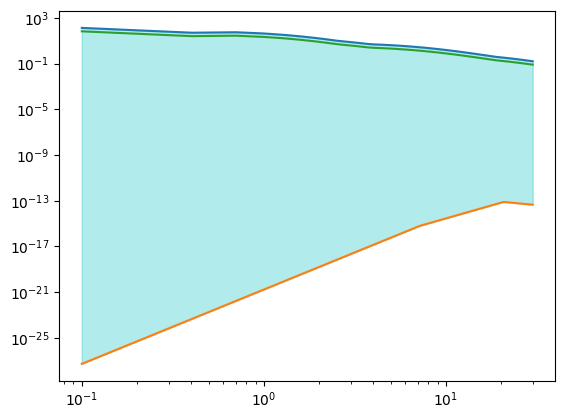

In [144]:
ax=plt.subplot()
ax.loglog(time,maximumoff)
ax.loglog(time,minimumoff)
ax.loglog(time,median)
#plt.ylim(10e-15,10)
ax.fill_between(time, maximumoff, minimumoff, color='c', alpha=0.3)

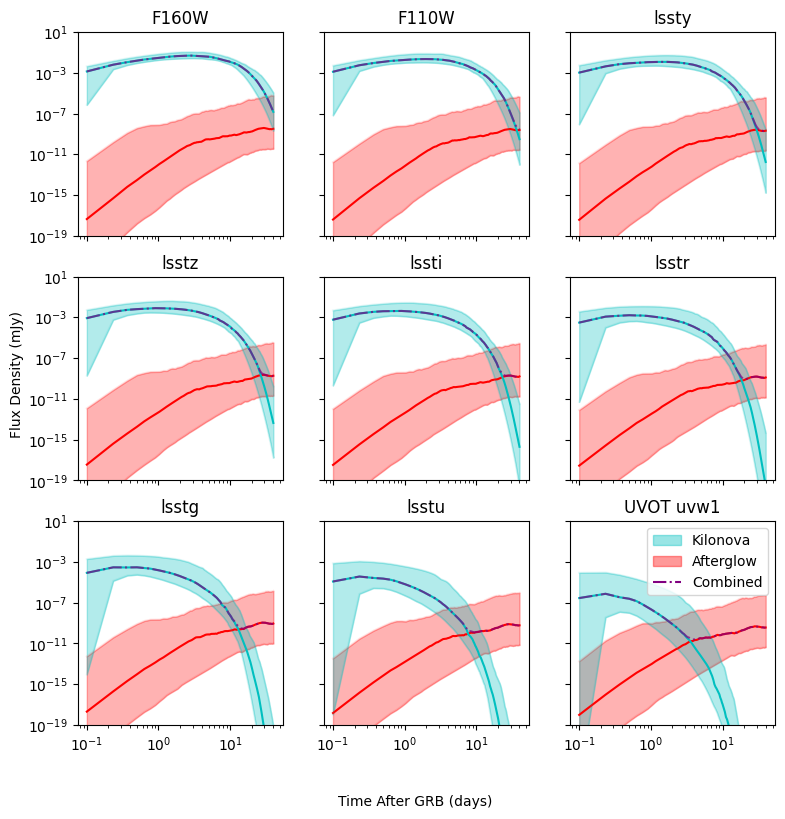

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,40,300)
#time2=np.linspace(0.1,40,100)

for j in range(3):
    
    for i in range(3):
        ax[j,i].loglog(time, loweroff[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].loglog(time, medianoff[i+(3*j)], c='r' )
        ax[j,i].loglog(time, upperoff[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].fill_between(time, loweroff[i+(3*j)], upperoff[i+(3*j)], color='r',  alpha=0.3)

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].loglog(time, mediankn[i+(3*j)], c='c')
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='c', alpha=0.3)
    
        ax[j,i].loglog(time, np.array(medianoff[i+(3*j)])+mediankn[i+(3*j)], c='purple', ls='-.', alpha=0.7)
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')
#['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']

kn = mpatches.Patch(color='c', label='Kilonova', alpha=0.4)
ag = mpatches.Patch(color='r', label='Afterglow', alpha=0.4)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
both= Line2D([0],[0], ls='-.', c='purple', label='Combined')

ax[2,2].legend(handles=[kn,ag,both])

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20,10)
plt.savefig("off68final.png", dpi='figure')

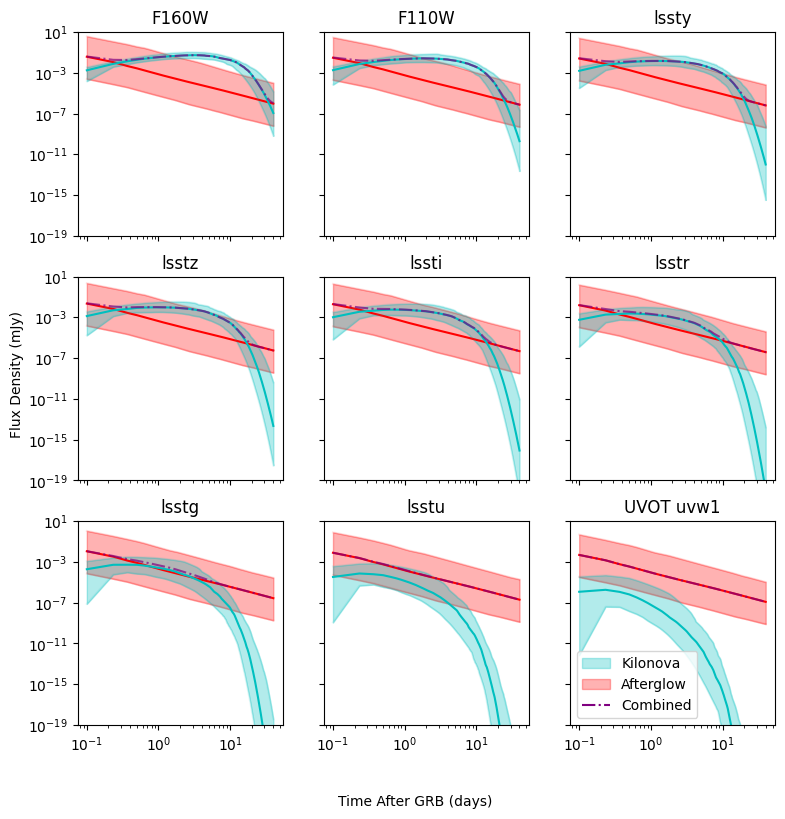

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time= np.linspace(0.1,40,300)

for j in range(3):
    
    for i in range(3):
        ax[j,i].loglog(time, loweron[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].loglog(time, medianon[i+(3*j)], c='r' )
        ax[j,i].loglog(time, upperon[i+(3*j)], c='r',  alpha=0.1)
        ax[j,i].fill_between(time, loweron[i+(3*j)], upperon[i+(3*j)], color='r',  alpha=0.3)

        ax[j,i].loglog(time, lowerkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].loglog(time, mediankn[i+(3*j)], c='c')
        ax[j,i].loglog(time, upperkn[i+(3*j)], c='c',  alpha=0.1)
        ax[j,i].fill_between(time, lowerkn[i+(3*j)], upperkn[i+(3*j)], color='c', alpha=0.3)
    
        ax[j,i].loglog(time, np.array(medianon[i+(3*j)])+mediankn[i+(3*j)], c='purple', ls='-.', alpha=0.7)
    
ax[0,0].set_title('F160W')
ax[0,1].set_title('F110W')
ax[0,2].set_title('lssty')
ax[1,0].set_title('lsstz')
ax[1,1].set_title('lssti')
ax[1,2].set_title('lsstr')
ax[2,0].set_title('lsstg')
ax[2,1].set_title('lsstu')
ax[2,2].set_title('UVOT uvw1')

kn = mpatches.Patch(color='c', label='Kilonova', alpha=0.3)
ag = mpatches.Patch(color='r', label='Afterglow', alpha=0.3)
#knline= Line2D([0],[0], ls='-', c='c', label='Kilonova median')
#agline= Line2D([0],[0], ls='-', c='r', label='Afterglow median')
both= Line2D([0],[0], ls='-.', c='purple', label='Combined')

plt.legend(handles=[kn,ag,both])

fig.text(0.5, 0.02, 'Time After GRB (days)', ha='center')
fig.text(0.05, 0.5, 'Flux Density (mJy)', va='center', rotation='vertical')

plt.ylim(10e-20, 10)
plt.savefig("on68_midconstraint.png", dpi='figure')